In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'  # carpeta donde se encuentran los datasets
else:
    FUENTES_DIR = '../Fuentes/' # carpeta LOCAL donde se encuentran los scripts
    DATOS_DIR   = '../Datos/' # carpeta LOCAL donde se encuentran los datasets

import sys
sys.path.append(FUENTES_DIR)
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
from sklearn import preprocessing
from ClassNeuronaGral import NeuronaGradiente
from ClassRNMulticlase import RNMulticlase
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier


def openFile(nomArch, sep=None):
    file = DATOS_DIR + nomArch
    #-- detectando la codificación de caracteres usada ----
    with open(file, 'rb') as f:
        result = chardet.detect(f.read()) 
    return pd.read_csv(file, encoding=result['encoding'], sep=sep, engine='python') # or readline if the file is large

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Oculta todos los warnings y mensajes de información 
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from livelossplot import PlotLossesKeras # Para mostrar el plot a medida que se entrena en vez de la barrita de progreso
from livelossplot.outputs import MatplotlibPlot
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

#### Ejercicio 1

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

a) Con el conjunto de 60000 imágenes entrene una red neuronal convolucional para predecir el dígito 
presente  en  la  imagen.

In [4]:
# Convertir las etiquetas a formato one-hot encoding
Y_train = to_categorical(np.array(Y_train))
Y_test = to_categorical(np.array(Y_test))

img_shape = X_train.shape[1:]  # (28, 28)
target_cnt = Y_train.shape[1]  # 10

# Normalizar las imágenes: Los valores originales de los píxeles van de 0 a 255
# Así los valores quedan entre 0 y 1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
# Generación del modelo
padding = 'same'  # Same para que las capas convolucionales no reduzcan la dimensión espacial
activ = 'relu'    # Función de activación ReLU

model = Sequential()

model.add(Input(shape=(*img_shape, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), strides=(
    1, 1), activation=activ, padding=padding))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(
    1, 1), activation=activ, padding=padding))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(
    1, 1), activation=activ, padding=padding))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation=activ))      
model.add(Dense(target_cnt, activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,114 (652.79 KB)

 Trainable params: 167,114 (652.79 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
LOTES  = 128
EPOCAS = 100
PACIENCIA = 10

# parada temprana para evitar el sobreajuste
early_stop = EarlyStopping(monitor='val_loss', patience=PACIENCIA, restore_best_weights=True )
# visual_plot = PlotLossesKeras( outputs=[ MatplotlibPlot(figsize=(12, 5)) ] )

# %% Entrenamiento del modelo usando datos de entrenamiento y validacion
H = model.fit(x=X_train, y=Y_train, batch_size=LOTES,
              epochs=EPOCAS,
              validation_split=0.3,
              #callbacks=[early_stop, visual_plot],
              callbacks=[early_stop],
              verbose=0
              )

model.save('modelo_ej_1.h5')

KeyboardInterrupt: 

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
from sklearn import metrics

# Crear subplots interactivos
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Pérdida', 'Accuracy',
                                    'Matriz de Confusión'),
                    )

# Gráfico de pérdida
fig.add_trace(go.Scatter(
    y=H.history["loss"], name="train_loss", mode='lines'),   row=1, col=1)
fig.add_trace(go.Scatter(
    y=H.history["val_loss"], name="val_loss", mode='lines'), row=1, col=1)

# Gráfico de accuracy
fig.add_trace(go.Scatter(
    y=H.history["accuracy"], name="train_acc", mode='lines'),   row=1, col=2)
fig.add_trace(go.Scatter(
    y=H.history["val_accuracy"], name="val_acc", mode='lines'), row=1, col=2)

# Matriz de confusión
pred = model.predict(X_train, verbose=0)
cm = metrics.confusion_matrix(
    np.argmax(Y_train, axis=1), np.argmax(pred, axis=1))

# Matriz de confusión con Plotly
confusion_heatmap = go.Heatmap(
    z=cm,
    x=[f'Pred {i}' for i in range(cm.shape[1])],
    y=[f'Real {i}' for i in range(cm.shape[0])],
    colorscale='Viridis',
    text=cm,
    texttemplate='%{text}',
    textfont={'size': 10},
)

# Agregar la matriz de confusión
fig.add_trace(confusion_heatmap, row=1, col=3)

fig.update_layout(
    height=450,
    width=1200,
    title={
        'text': "Métricas de Entrenamiento",
        'font': dict(size=20),
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center'},
    legend=dict(
        orientation="v",
        yanchor="bottom",
        y=0.1,
        xanchor="center",
        x=0.57
    ),
    margin=dict(t=100, b=50, l=50, r=50)
)

fig.show()

# Resto del código para imprimir métricas
print("\nEfectividad del modelo con datos de entrenamiento: %6.2f%%" %
      (H.history['accuracy'][-1]*100))
print("Efectividad del modelo con datos de validación...: %6.2f%%" %
      (H.history['val_accuracy'][-1]*100))

# Evalua el modelo con datos de prueba
pred = model.evaluate(X_test, Y_test, verbose=0)
print("Efectividad del modelo con datos de Prueba.......: %6.2f%%\n" %
      (pred[1]*100))
pred = model.predict(X_test, verbose=0)
print(metrics.classification_report(
    np.argmax(Y_test, axis=1), np.argmax(pred, axis=1)))

b) Levante el modelo guardado en el punto a) y utilice la clase DrawPanel del módulo utils.images de 
la  carpeta  fuentes  para  generar  un  dibujo  escrito  a  mano  de  un  dígito  y  predecir  la  clase  a  la  que 
pertenece. (Solamente se puede hacer en colab)

#### Ejercicio 2

In [ ]:
# Los datos son los mismos que en el ejercicio 1
es = EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)

# Definir los parámetros de la tabla
experimentos = [
    {'F': 4, 'K': (3,3), 'S': 1, 'FUN': 'relu', 'MaxPool': True},
    {'F': 16, 'K': (3,3), 'S': 1, 'FUN': 'relu', 'MaxPool': True},
    {'F': 64, 'K': (3,3), 'S': 1, 'FUN': 'relu', 'MaxPool': True},
    {'F': 4, 'K': (7,7), 'S': 1, 'FUN': 'relu', 'MaxPool': True},
    {'F': 16, 'K': (7,7), 'S': 1, 'FUN': 'relu', 'MaxPool': True},
    {'F': 64, 'K': (7,7), 'S': 1, 'FUN': 'relu', 'MaxPool': True},
    {'F': 64, 'K': (3,3), 'S': 2, 'FUN': 'relu', 'MaxPool': False},
    {'F': 64, 'K': (3,3), 'S': 3, 'FUN': 'relu', 'MaxPool': False},
    {'F': 64, 'K': (3,3), 'S': 1, 'FUN': 'tanh', 'MaxPool': True},
    {'F': 64, 'K': (3,3), 'S': 1, 'FUN': 'sigmoid', 'MaxPool': True}
]

# Lista para almacenar resultados
resultados = []

In [ ]:
for i, params in enumerate(experimentos):
    print(f"\n--- Experimento {i+1}/10 ---")
    print(f"Filtros: {params['F']}, Kernel: {params['K']}, Stride: {params['S']}, Activación: {params['FUN']}, MaxPool: {params['MaxPool']}")
    
    # Crear modelo
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(Conv2D(params['F'], kernel_size=params['K'], strides=(params['S'], params['S']), activation=params['FUN']))
    
    # Agregar MaxPooling si está especificado
    if params['MaxPool']:
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    
    # Compilar modelo
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Callback para parada temprana
    early_stop = EarlyStopping(monitor='val_loss', patience=PACIENCIA, restore_best_weights=True)
    
    # Entrenar modelo
    H = model.fit(x=X_train, y=Y_train, 
                    batch_size=LOTES,
                    epochs=EPOCAS,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=0)
    
    # Evaluar en conjunto de prueba
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
    
    # Obtener métricas finales
    train_acc = H.history['accuracy'][-1]
    val_acc = H.history['val_accuracy'][-1]
    epocas_entrenadas = len(H.history['accuracy'])
    total_params = model.count_params()
    
    # Guardar resultados
    resultado = {
        'Cant_filtros': params['F'],
        'Tamaño_kernel': f"{params['K'][0]}x{params['K'][1]}",
        'Stride': params['S'],
        'Funcion_activacion': params['FUN'],
        'MaxPooling': 'Si' if params['MaxPool'] else 'No',
        'Total_parametros': total_params,
        'Epocas': epocas_entrenadas,
        'Accuracy_Train': f"{train_acc*100:.2f}%",
        'Accuracy_Test': f"{test_acc*100:.2f}%"
    }
    
    print(f"Parámetros: {total_params}, Épocas: {epocas_entrenadas}, Test Acc: {test_acc*100:.2f}%")
    
    resultados.append(resultado)

# Crear DataFrame y mostrar tabla completa
df_resultados = pd.DataFrame(resultados)

In [ ]:
print("\n" + "="*120)
print("TABLA COMPLETA DE RESULTADOS")
print("="*120)

# Configurar pandas para mostrar toda la tabla
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(df_resultados.to_string(index=False))

# Análisis de resultados
print("\n" + "="*120)
print("ANÁLISIS DE RESULTADOS")
print("="*120)

# Encontrar el mejor modelo
df_valid = df_resultados[df_resultados['Accuracy_Test'] != 'Error'].copy()
if not df_valid.empty:
    df_valid['Test_Acc_Numeric'] = df_valid['Accuracy_Test'].str.replace('%', '').astype(float)
    mejor_modelo_idx = df_valid['Test_Acc_Numeric'].idxmax()
    mejor_modelo = df_resultados.iloc[mejor_modelo_idx]
    
    print(f"Mejor modelo:")
    print(f"- Configuración: {mejor_modelo['Cant_filtros']} filtros, {mejor_modelo['Tamaño_kernel']}, stride {mejor_modelo['Stride']}, {mejor_modelo['Funcion_activacion']}")
    print(f"- Accuracy en Test: {mejor_modelo['Accuracy_Test']}")
    print(f"- Total parámetros: {mejor_modelo['Total_parametros']}")
    print(f"- Épocas entrenadas: {mejor_modelo['Epocas']}")

# Guardar resultados en CSV
df_resultados.to_csv('resultados_experimentos_cnn.csv', index=False)
print(f"\nResultados guardados en 'resultados_experimentos_cnn.csv'")

#### Ejercicio 3

In [ ]:
import zipfile
import os

# Descomprimir en la misma carpeta
with zipfile.ZipFile(os.path.join(DATOS_DIR, 'Fingers.zip'), 'r') as zip_ref:
    zip_ref.extractall(os.path.join(DATOS_DIR, 'Fingers'))

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Oculta todos los warnings y mensajes de información 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

IMG_ERROR = 'No hay imágenes para cargar. Verificar que la ruta sea correcta y que la carpeta tenga imagenes con la extensión usada'

def import_data(data_dir):

    img_list = glob.glob(data_dir)      # Obtener la lista de archivos de imágenes

    assert len(img_list) > 0, IMG_ERROR # verifica que la ruta sea correcta y tenga al menos 1 imagen

    img_data = []  # lista de imagenes
    lbl_data = []  # lista de etiquetas

    img_count = len(img_list)
    for i, img_path in enumerate(img_list):

        img = Image.open(img_path)          # Carga imagen
        img = np.array(img) / np.max(img)   # Normaliza los píxeles entre 0 y 1
        img = img.reshape((*img.shape, 1))  # Formatea la imagen para TF: WxH => WxHx1. Asegura formato de batch ¿Qué es esto?

        # Almacenar la imagen y la etiqueta
        img_data.append(img)
        # ej. nombre de archivo: 000e7aa6-100b-4c6b-9ff0-e7a8e53e4465_5L.png
        lbl_data.append(int(img_path[-6]))  # Extrae la cantidad de dedos del nombre del archivo

        # Mostrar progreso en la carga
        if i % 100 == 0:
            print("\rCargando imágenes: %6.2f%%" % (100 * i / img_count), end="")

    print("\rCargando imágenes: 100.00%% (%d) \n" % img_count)

    return np.array(img_data), np.array(lbl_data)


# carga las imagenes a partir de los nombres de archivos
x_train, y_train = import_data(DATOS_DIR+"Fingers/train/*/*.png")

# carga las imagenes a partir de los nombres de archivos
x_test, y_test = import_data(DATOS_DIR+"Fingers/test/*/*.png")

# separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.30, shuffle = True)


In [ ]:
# clases (0..5) por ejemplo
display(y_train)
# cantidad de ejemplos por clase (0..5)
display(np.bincount(y_train))

In [ ]:
EPOCAS = 100
LOTES  = 128
PACIENCIA=5
IMG_SIZE = x_train.shape[1:]
N_CLASSES = len(np.unique(y_train))
ACTIVA =LeakyReLU()

# Construye el modelo
model = Sequential()

model.add(Input( shape=IMG_SIZE ))
model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(32, activation = ACTIVA))
model.add(Dense(N_CLASSES, activation = 'softmax'))

model.summary()

# construye el modelo
optimizer = optimizers.Adam(0.001)
# Observar que con "sparse_categorical_crossentropy" no hace falta codificacion one-hot para las clases
model.compile(optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


# parada temprana para evitar el sobreajuste
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA, min_delta=0.001, restore_best_weights=True )

# entrena el modelo y guarda la historia del progreso
H = model.fit(x_train,
              y_train,
              batch_size = LOTES,
              epochs = EPOCAS,
              validation_data = (x_val, y_val),
              callbacks=[early_stop]
             )

In [ ]:
import tensorflow as tf

IMG_SIZE = (64, 64, 1)
N_CLASSES = 6
LOTES = 128

# Crear datasets usando tf.data (más moderno y eficiente)
def rotate_and_flip_images(directory):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        seed=123,
        image_size=(IMG_SIZE[0], IMG_SIZE[1]),
        batch_size=LOTES,
        color_mode='grayscale',
    )

    # Normalizar a [0,1]
    def preprocess(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    def rotate_and_flip(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.rot90(image, k=1)
        return image, label
    
    # Aplica preprocesamiento y aumento de datos
    dataset = dataset.map(preprocess)
    dataset = dataset.map(rotate_and_flip)

    return dataset.cache().prefetch(tf.data.AUTOTUNE)

test_ds = rotate_and_flip_images(
    DATOS_DIR + 'Fingers/test',
)

model.evaluate(test_ds) # [18.18547821044922, 0.3333333432674408]
# Entonces podemos observar que al rotar las imágenes de prueba 90 grados, la efectividad del modelo cae drásticamente. 
# Esto indica que el modelo no es robusto a rotaciones, lo cual es un aspecto importante a considerar en tareas de clasificación de imágenes.

Se crean los dataset de entrenamiento con data augmentation para poder detectar fotos rotadas

In [ ]:
def create_dataset(directory, validation_split=None, subset=None, shuffle=True):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=validation_split,
        subset=subset,
        seed=123,
        image_size=(IMG_SIZE[0], IMG_SIZE[1]),
        batch_size=LOTES,
        color_mode='grayscale',
        shuffle=shuffle
    )

    # Normalizar a [0,1] y aplicar data augmentation
    def preprocess(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    def augment(image, label):
        image = tf.image.rot90(image, k=1)
        return image, label

    dataset = dataset.map(preprocess)
    if subset == 'training':
        dataset = dataset.map(augment)  # Solo aumentar datos de entrenamiento

    return dataset.cache().prefetch(tf.data.AUTOTUNE)

# Crear datasets
train_ds = create_dataset(
    DATOS_DIR + 'Fingers/train',
    validation_split=0.2,
    subset='training',
    shuffle=True
)

valid_ds = create_dataset(
    DATOS_DIR + 'Fingers/train',
    validation_split=0.2,
    subset='validation',
    shuffle=False
)

# Los datos de testeo ya fueron rotados y aumentados previamente

In [ ]:
# Creamos el modelo CNN
EPOCAS = 50
PACIENCIA = 4
ACTIVA = LeakyReLU()

model = Sequential()
model.add(Input(shape=IMG_SIZE))
model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation=ACTIVA))
model.add(Dense(N_CLASSES, activation='softmax'))

optimizer = optimizers.Adam(0.001)
model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=PACIENCIA, restore_best_weights=True)

# Etiquetas de los datos de entrenamiento:
etiquetas = np.unique(np.concatenate([y for x, y in train_ds], axis=0))
print(f"Como las clases de entrenamiento son: {etiquetas} podemos usar sparse_categorical_crossentropy, ya que no es necesario one-hot encoding.")
print("\n")

# Entrenar (cambia los iteradores por datasets)
H = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCAS,
    callbacks=[early_stop],
    verbose=1
)

Ahora, una vez entrneado el modelo con más datos, volvemos a evaluarlo con los datos de testeo

In [ ]:
model.evaluate(test_ds) # [0.028165370225906372, 0.9927777647972107]

#### Ejercicio 4

Inicializar el Generador (Aumento de Datos)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

directory = DATOS_DIR + 'Fingers/train'
# 1. Crear los generadores de datos de entrenamiento con escalado y rotación
data_train_generator = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=45,         # rotacion
    rescale=1./255,            # escalado [0,1]
    # zoom_range=0.15,         # zoom
    # width_shift_range=0.1,   # desplazamiento horizontal
    # height_shift_range=0.1,  # desplazamiento vertical
    # shear_range=0.15,        #
    # horizontal_flip=False,   # espejo horizontal
    # vertical_flip=False,     # espejo vertical
    fill_mode="reflect" # rellena los bordes reflejando la imagen para que no se tomen como un patrón
    )

# 2. Crear los generadores de datos prueba y validación (sin aumento, solo escalado)
data_test_generator = ImageDataGenerator(
    rotation_range=60,         # rotacion
    rescale=1./255,            # escalado [0,1]
    # zoom_range=0.15,         # zoom
    # width_shift_range=0.1,   # desplazamiento horizontal
    # height_shift_range=0.1,  # desplazamiento vertical
    # shear_range=0.15,        #
    # horizontal_flip=False,   # espejo horizontal
    # vertical_flip=False,     # espejo vertical
    fill_mode="reflect"
    )


Inicializar los generadores y obtener los datos de preba/validación/testeo

In [ ]:
LOTES = 32
IMG_SIZE = (64, 64, 1)
N_CLASSES = 6

# 1. Generador para entrenamiento a partir de la carpeta con datos de entrenamiento
train_iter = data_train_generator.flow_from_directory( # Para recuperar las imagenes de la carpeta
            target_size=(IMG_SIZE[0],IMG_SIZE[1]),
            directory=DATOS_DIR+'Fingers/train', # carpeta de datos
            class_mode='categorical',            # utiliza codificacion one-hot, va a ir a buscar las subcarpetas y el nombre de cada una lo toma como etiqueta
            batch_size=LOTES,                    # Tamaño del lote
            color_mode='grayscale',              # aplica transformación
            subset='training'                    # asigna subconjunto por validation_split del ImageDataGenerator
            )

# 2. Generador para validación a partir de la carpeta con datos de entrenamiento
valid_iter = data_train_generator.flow_from_directory(
            target_size=(IMG_SIZE[0],IMG_SIZE[1]),
            directory=DATOS_DIR+'Fingers/train', # carpeta de datos
            class_mode='categorical',            # utiliza codificacion one-hot
            batch_size=LOTES,                    # Tamaño del lote
            color_mode='grayscale',              # aplica transformación
            subset='validation'                  # asigna subconjunto por validation_split del ImageDataGenerator
            )

# 3. Generador para testeo a partir de la carpeta con datos de testeo
test_iter = data_test_generator.flow_from_directory(
            target_size=(IMG_SIZE[0],IMG_SIZE[1]),
            directory=DATOS_DIR+'Fingers/test',     # carpeta de datos
            class_mode='categorical',               # utiliza codificacion one-hot
            color_mode='grayscale',                 # aplica transformación
            batch_size=LOTES                        # Tamaño del lote
            )

Found 14400 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.


Entrenamiento y evaluación del modelo

In [ ]:
EPOCAS = 50
LOTES  = 128
PACIENCIA=4

import tensorflow as tf

from tensorflow.keras.layers import LeakyReLU

FN_ACTIVA = LeakyReLU()

# Construye el modelo
model = Sequential()

model.add(Input(shape=IMG_SIZE))
model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(FN_ACTIVA)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation=FN_ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation = FN_ACTIVA))
model.add(Dense(6, activation = 'softmax'))

model.summary()

# construye el modelo
optimizer = 'Adam' #optimizers.Adam(0.001)
model.compile(optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])


# parada temprana para evitar el sobreajuste
early_stop = EarlyStopping(monitor='val_loss', patience=PACIENCIA, restore_best_weights=True)

# H = model.fit(
#     train_iter,
#     validation_data=valid_iter,
#     epochs=EPOCAS,
#     callbacks=[early_stop],
#     verbose=1)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529,542 (2.02 MB)

 Trainable params: 529,542 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.evaluate(test_iter)

In [ ]:
# Punto b)
from tensorflow.keras.utils import image_dataset_from_directory

SPLIT_SEED = 42  # Usa cualquier número entero fijo

# --- A. Generar el Dataset de Entrenamiento ---
dataset_train = image_dataset_from_directory(
    directory=directory,
    image_size=(64, 64),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,       # 20% reservado para validación
    subset='training',          # Pedimos el 80% restante para entrenamiento
    seed=SPLIT_SEED,            # Usamos la misma semilla
    shuffle=True,                # Activamos shuffle para el entrenamiento
    color_mode='grayscale'
)

# --- B. Generar el Dataset de Validación ---
dataset_val = image_dataset_from_directory(
    directory=directory,
    image_size=(64, 64),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,       # Mismo porcentaje de división
    subset='validation',        # Pedimos el 20% para validación
    seed=SPLIT_SEED,            # Usamos la MISMA semilla para obtener las imágenes reservadas
    # Desactivamos shuffle para la validación (para trazabilidad)
    shuffle=False,
    color_mode='grayscale'
)

dataset_test = image_dataset_from_directory(directory.replace(
    "train", "test"), shuffle=False, batch_size=32, image_size=(64, 64), color_mode='grayscale', label_mode='categorical')

Found 18000 files belonging to 6 classes.
Using 14400 files for training.
Found 18000 files belonging to 6 classes.
Using 3600 files for validation.
Found 3600 files belonging to 6 classes.


Data augmentation

In [ ]:
# Definir el pipeline de aumento de datos
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.125), # Equivalente a +/- 45 grados (0.125 * 360 = 45)
    tf.keras.layers.RandomFlip("horizontal"),
])

# Aplicar el aumento SOLO al conjunto de entrenamiento
dataset_train = dataset_train.map(lambda x, y: (data_augmentation(x), y))

Generación del modelo

In [ ]:
# Creamos el modelo CNN
EPOCAS = 50
PACIENCIA = 4
ACTIVA = LeakyReLU()

model = Sequential()
model.add(Input(shape=IMG_SIZE))
model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation=ACTIVA))
model.add(Dense(N_CLASSES, activation='softmax'))

optimizer = optimizers.Adam(0.001)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=PACIENCIA, restore_best_weights=True)

# Entrenar (cambia los iteradores por datasets)
H = model.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=EPOCAS,
    callbacks=[early_stop],
    verbose=1
)

Como las clases de entrenamiento son: [0. 1.] podemos usar sparse_categorical_crossentropy, ya que no es necesario one-hot encoding.


Epoch 1/50
  7/450 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1715 - loss: 113.1954

E0000 00:00:1760797747.953482  292493 meta_optimizer.cc:967] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/sequential_10_1/conv2d_15_1/leaky_re_lu_6_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/sequential_10_1/conv2d_15_1/BiasAdd'.


450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.8906 - loss: 3.7029 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.9872 - loss: 0.0402 - val_accuracy: 0.9964 - val_loss: 0.0089
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9958 - loss: 0.0138 - val_accuracy: 0.9989 - val_loss: 0.0037
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.9903 - loss: 0.0310 - val_accuracy: 0.9992 - val_loss: 0.0020
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.9937 - loss: 0.0175 - val_accuracy: 0.9967 - val_loss: 0.0075
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.9957 - loss: 0.0120 - val_accuracy: 0.9997 - val_loss: 9.4642e-04
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9901 - loss: 0.0415 - val_accuracy: 0.9983 - val_loss: 0.0055
Epoch 8/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.9941 - loss: 0.0279 - val_acc

In [ ]:
model.evaluate(dataset_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9981 - loss: 0.0074


[0.007434009108692408, 0.9980555772781372]

#### Ejercicio 5

In [ ]:
# Extraer zip
import zipfile
import os

# --- 1. Definir Rutas ---
zip_file_path = os.path.join(DATOS_DIR, "FlowersX16.zip")
extract_dir = DATOS_DIR  # O elegí otra carpeta de destino, ej: 'DATOS_DIR/FlowersX16_data'

# --- 2. Extraer el Archivo ZIP ---
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extrae todos los contenidos del ZIP al directorio de destino
        zip_ref.extractall(extract_dir)
    print(f"El archivo '{zip_file_path}' ha sido extraído exitosamente en '{extract_dir}'.")

except FileNotFoundError:
    print(f"Error: No se encontró el archivo ZIP en la ruta: {zip_file_path}")
except zipfile.BadZipFile:
    print(f"Error: El archivo ZIP parece estar corrupto o no es un archivo ZIP válido.")
except Exception as e:
    print(f"Ocurrió un error inesperado al extraer el ZIP: {e}")

El archivo '../Datos/FlowersX16.zip' ha sido extraído exitosamente en '../Datos/'.


Crear los datasets de train/test/validation

In [ ]:
IMG_SIZE = (96, 96, 1)
SPLIT_SEED = 42  # Usa cualquier número entero fijo

dataset_train = image_dataset_from_directory(
    directory=DATOS_DIR + 'FlowersX16/',
    image_size=IMG_SIZE[:2],
    batch_size=32,
    label_mode='categorical',
    shuffle=True,
    color_mode='grayscale',
    validation_split=0.2,
    subset='training',
    seed=SPLIT_SEED
)

dataset_val = image_dataset_from_directory(
    directory=DATOS_DIR + 'FlowersX16/',
    image_size=IMG_SIZE[:2],
    batch_size=32,
    label_mode='categorical',
    shuffle=False,
    color_mode='grayscale',
    validation_split=0.2,
    subset='validation',
    seed=SPLIT_SEED
)

Found 15740 files belonging to 16 classes.
Using 12592 files for training.
Found 15740 files belonging to 16 classes.
Using 3148 files for validation.


Creación del modelo con Conv2D, MaxPooling2D, Flatten y Dense

In [ ]:
FUN_ACTIVA = LeakyReLU()

model = Sequential()
model.add(Input(shape=IMG_SIZE))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation=FUN_ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation=FUN_ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation=FUN_ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation=FUN_ACTIVA))
model.add(Dense(16, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

H = model.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
  1/394 ━━━━━━━━━━━━━━━━━━━━ 6:24 978ms/step - accuracy: 0.0938 - loss: 22.1171

E0000 00:00:1760806340.358452  292493 meta_optimizer.cc:967] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/sequential_13_1/conv2d_25_1/leaky_re_lu_8_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/sequential_13_1/conv2d_25_1/BiasAdd'.


394/394 ━━━━━━━━━━━━━━━━━━━━ 78s 197ms/step - accuracy: 0.2193 - loss: 5.1168 - val_accuracy: 0.5775 - val_loss: 1.5105
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 78s 198ms/step - accuracy: 0.4413 - loss: 1.8369 - val_accuracy: 0.8008 - val_loss: 0.8312
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 78s 198ms/step - accuracy: 0.6126 - loss: 1.2597 - val_accuracy: 0.8558 - val_loss: 0.5848
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 77s 197ms/step - accuracy: 0.7574 - loss: 0.7765 - val_accuracy: 0.8520 - val_loss: 0.5945
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 79s 201ms/step - accuracy: 0.8115 - loss: 0.5788 - val_accuracy: 0.8008 - val_loss: 0.8273
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 81s 207ms/step - accuracy: 0.8300 - loss: 0.5464 - val_accuracy: 0.8170 - val_loss: 0.8459
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 82s 209ms/step - accuracy: 0.8570 - loss: 0.4746 - val_accuracy: 0.8161 - val_loss: 0.8948
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 82s 207ms/step - accuracy: 0.8384 - loss: 0.5602 - val

In [ ]:
model.evaluate(dataset_train)

394/394 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.7899 - loss: 0.6960


[0.6959676742553711, 0.7899460196495056]

Ahora agregamos capas de BatchNormalization

In [ ]:
from tensorflow.keras.layers import BatchNormalization

FUN_ACTIVA = LeakyReLU()

model = Sequential()
model.add(Input(shape=IMG_SIZE))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation=FUN_ACTIVA))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation=FUN_ACTIVA))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation=FUN_ACTIVA))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation=FUN_ACTIVA))
model.add(BatchNormalization())
model.add(Dense(16, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

H = model.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


E0000 00:00:1760807323.102236  292493 meta_optimizer.cc:967] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/sequential_14_1/conv2d_28_1/leaky_re_lu_9_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/sequential_14_1/conv2d_28_1/BiasAdd'.


394/394 ━━━━━━━━━━━━━━━━━━━━ 141s 354ms/step - accuracy: 0.3202 - loss: 2.2433 - val_accuracy: 0.6541 - val_loss: 1.3054
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 128s 325ms/step - accuracy: 0.5043 - loss: 1.6357 - val_accuracy: 0.7678 - val_loss: 0.8755
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 129s 328ms/step - accuracy: 0.6317 - loss: 1.2010 - val_accuracy: 0.7767 - val_loss: 0.8378
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 120s 305ms/step - accuracy: 0.7730 - loss: 0.7548 - val_accuracy: 0.8116 - val_loss: 0.6650
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 128s 326ms/step - accuracy: 0.8848 - loss: 0.3949 - val_accuracy: 0.8780 - val_loss: 0.4991
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 153s 387ms/step - accuracy: 0.9435 - loss: 0.2104 - val_accuracy: 0.7662 - val_loss: 0.9966
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 138s 351ms/step - accuracy: 0.9686 - loss: 0.1253 - val_accuracy: 0.8980 - val_loss: 0.4554
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 120s 305ms/step - accuracy: 0.9753 - loss: 0.09

In [ ]:
model.evaluate(dataset_train)

394/394 ━━━━━━━━━━━━━━━━━━━━ 49s 124ms/step - accuracy: 0.9090 - loss: 0.2697


[0.2696598768234253, 0.9089898467063904]

#### Comparación de Métricas
Modelo A (Sin Batch Norm)
- Pérdida: 0.696
- Precisión: 79.0%

Modelo B (Con Batch Norm) 
- Pérdida: 0.270.
- Precisión: 90.9%.

🧠 ¿Por Qué Batch Normalization es tan Efectivo?
Batch Normalization (BN) resuelve un problema fundamental en el entrenamiento de redes profundas conocido como "Internal Covariate Shift" (Cambio Interno de Covarianza).

Pensemos en la red como una cadena de aprendizaje: la capa 2 aprende de la salida de la capa 1, la capa 3 de la salida de la capa 2, y así sucesivamente.

Sin BN (Modelo A): A medida que los pesos de la capa 1 se actualizan, la distribución de sus datos de salida cambia constantemente. Esto obliga a la capa 2 a readaptarse continuamente a un "objetivo en movimiento". Es un proceso de aprendizaje inestable y lento, como tratar de darle a un blanco que no para de moverse. Esto explica tu loss relativamente alto (0.696) y una precisión decente pero no excelente (79%).

Con BN (Modelo B): La capa BatchNormalization se coloca entre dos capas y actúa como un "regulador". Toma la salida de la capa anterior y la normaliza, asegurando que siempre tenga una media cercana a 0 y una desviación estándar cercana a 1.

Esto tiene varios efectos increíblemente positivos:

Estabiliza el Aprendizaje: Al recibir siempre datos con una distribución estable y predecible, la siguiente capa puede aprender de manera mucho más eficiente y rápida. El "blanco" se queda quieto, lo que permite a la red converger mucho más rápido y a una solución mejor.

Acelera el Entrenamiento: Como el aprendizaje es más estable, el modelo necesita menos épocas para alcanzar un buen rendimiento. Tu EarlyStopping probablemente se activó mucho antes en el segundo modelo.

Actúa como Regularizador: La ligera aleatoriedad introducida al normalizar por batch en lugar de por todo el dataset tiene un efecto de regularización, lo que ayuda a prevenir el sobreajuste (overfitting).

Permite Tasas de Aprendizaje más Altas: La red se vuelve menos sensible a la escala de los pesos, lo que a menudo permite usar un learning rate más alto sin que el entrenamiento diverja.

Tu resultado lo demuestra a la perfección: el loss se desplomó a 0.270 (la red está mucho más segura de sus predicciones) y la precisión subió al 90%, todo gracias a que el proceso de aprendizaje fue más fluido y estable.

#### Ejercicio 6

#### Ejercicio 7

In [26]:
import  glob
import matplotlib.pyplot as plt
import zipfile
import os
import librosa
from IPython.display import Audio, display, HTML
import  sys
sys.path.append('..')
from Fuentes import audio as ta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Flatten,Dropout,Dense, Input, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import skimage.io as io
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import LeakyReLU


Extraer archivos y setear variables globales

In [8]:
def extraer_nombre_archivo(filename):
    # formato esperado :voz\\013F96_M_CERO.ogg
    idx = filename.rfind('_') # busca el "_" comenzando desde atras

    return filename[idx+1:-4]



FILTROS_MEL  = 64    # cantidad de filtros/coeficientes MEL a calcular
TIEMPO_AUDIO = 0.75  # longitud en segundos que deberan tener todos los audios
# tiempo mínimo de audio que debe superar un segmento considerado como NO silencio
# dentro del audio. Es un intento para recortar teclas al iniciar y terminar la grabacion
AUDIO_VALIDO_SEGS = 0.10

IMG_ERROR = 'No hay imagenes para cargar. Verificar que la ruta sea correcta y que la carpeta tenga imagenes con la extension usada'
DIR_TRAIN  = DATOS_DIR + 'Voz/Palabras/Train/*.ogg'
DIR_TEST   = DATOS_DIR + 'Voz/Palabras/Test/*.ogg'

archivos_train= glob.glob(DIR_TRAIN)
archivos_test = glob.glob(DIR_TEST)
assert len(archivos_train) > 0, IMG_ERROR

print(f'Se encontraron {len(archivos_train)} archivos de audio en la carpeta {DIR_TRAIN}'
)

Se encontraron 10282 archivos de audio en la carpeta ../Datos/Voz/Palabras/Train/*.ogg


Visualización de audios y pre-procesamiento

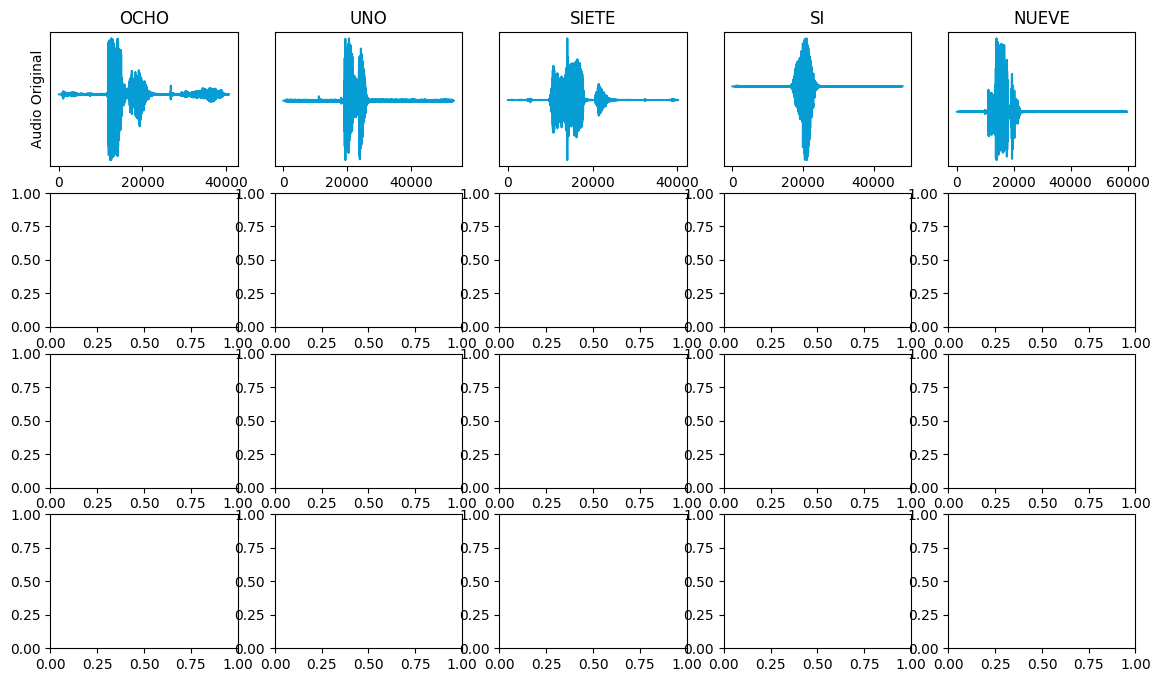

In [16]:
GRAF_CNT = 5
fig, axs = plt.subplots(4, GRAF_CNT, figsize=(14,8))

for i in range(GRAF_CNT):

    archivo = archivos_train[i]
    palabra = extraer_nombre_archivo(archivo)
    # carga archivo, retorna audio y frecuencia de muestreo
    audio, muestreo = librosa.load(archivo)

    #axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[0,i].plot(audio, color="#069DD4")
    axs[0,i].set_title(palabra)
    if i==0:
        axs[0,i].set_ylabel("Audio Original")

    # recorta  "silencios" antes y despues del audio. Esto es porque los silencios
    # coinciden al comparar 2 audios, algo  que se debe evitar para mejorar la efectividad
    #audio_sin_silencios = audio.recortar_silencios(audio, muestreo, AUDIO_VALIDO_SEGS)
    audio_sin_silencios = ta.recortar_silencios(audio)

    # ajusta longitud del audio para que coincida con TIEMPO_AUDIO (achica o agranda).
    # El ajuste lo hace sin perder el tono
    audio_ajustado= ta.ajustar_largo_audio(audio_sin_silencios, muestreo, TIEMPO_AUDIO)

    espectrograma_mel = ta.audio_a_espectrograma_mel(audio_ajustado, muestreo, FILTROS_MEL)


#### Entrenamiento del modelo

Preparación de datos

In [23]:
# Generar las imágenes a partir de los audios

def audios_a_lista_de_imagenes(archivos):
    img_list = []
    labels_list = []
    img_shape = None
    # tamano de imagen extraido de los datos

    for i in range(len(archivos)):
        archivo = archivos[i]
        palabra = extraer_nombre_archivo(archivo)
        # carga archivo, retorna audio y frecuencia de muestreo
        audio, muestreo = librosa.load(archivo)

        # recorta  "silencios" antes y despues del audio. Esto es porque los silencios
        # coinciden al comparar 2 audios, algo  que se debe evitar para mejorar la efectividad
        #audio_sin_silencios = audio.recortar_silencios(audio, muestreo, AUDIO_VALIDO_SEGS)
        audio_sin_silencios = ta.recortar_silencios(audio)

        # ajusta longitud del audio para que coincida con TIEMPO_AUDIO (achica o agranda).
        # El ajuste lo hace sin perder el tono
        audio_ajustado= ta.ajustar_largo_audio(audio_sin_silencios, muestreo, TIEMPO_AUDIO)

        espectrograma_mel = ta.audio_a_espectrograma_mel(audio_ajustado, muestreo, FILTROS_MEL)
        espectrograma_mel_img = ta.espectrograma_mel_a_imagen(espectrograma_mel)

        if img_shape is None:
            # Los espectrogramas (imágenes) generados por tu código son 2D (alto, ancho)
            # Para Keras/TensorFlow, necesitas (alto, ancho, canales)
            img_shape = (espectrograma_mel_img.shape[0], espectrograma_mel_img.shape[1], 1)
            print("Entré")

        img_list.append(espectrograma_mel_img)
        labels_list.append(palabra)

    return img_list, labels_list, img_shape


# Lista de archivos para entrenamiento
train_img_list, train_labels_list, IMG_SIZE = audios_a_lista_de_imagenes(archivos_train)
test_img_list, test_labels_list, IMG_SIZE = audios_a_lista_de_imagenes(archivos_test)
assert len(train_img_list) > 0, IMG_ERROR

# carga las imagenes a partir de los nombres de archivos
# xtrain, yraw = import_data(train_img_list)





# cantidad de pasadas de los datos
EPOCAS = 200
# cantidad de datos a procesar para actualizar pesos
LOTES  = 300

# %% binariza valores del target

# conviertes el id de la clase en "one hot encoding": clase 3 => [0,0,0,1,0,0]
# Binarizador para convertir el nombre de la clase en one hot encoding
binarizador = preprocessing.LabelBinarizer()
ytrain= binarizador.fit_transform(train_labels_list)


# cantidad de clases
# N_CLASSES = len(np.unique(yraw))
CLASES  = binarizador.classes_

# %% Separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(train_img_list, ytrain, test_size = 0.10, shuffle=True)

Entré


/home/santi/Documentos/Cuarto/Deep Learning/mi_entorno/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1920
  warnings.warn(
/home/santi/Documentos/Cuarto/Deep Learning/mi_entorno/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=384
  warnings.warn(
/home/santi/Documentos/Cuarto/Deep Learning/mi_entorno/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/home/santi/Documentos/Cuarto/Deep Learning/mi_entorno/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1664
  warnings.warn(
/home/santi/Documentos/Cuarto/Deep Learning/mi_entorno/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1792
  warnings.warn(
/h

Entré


/home/santi/Documentos/Cuarto/Deep Learning/Prácticas/Práctica 5/../Fuentes/audio.py:39: RuntimeWarning: invalid value encountered in divide
  mels = (mels-mels.min()) / (mels.max()-mels.min())
/home/santi/Documentos/Cuarto/Deep Learning/Prácticas/Práctica 5/../Fuentes/audio.py:48: RuntimeWarning: invalid value encountered in cast
  img = ( 255.0*mels).astype(np.uint8)
/home/santi/Documentos/Cuarto/Deep Learning/mi_entorno/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


Construcción del modelo

In [27]:
def build_model(img_size, classes):
    model = Sequential()

    # La forma de entrada debe ser (height, width, channels)
    model.add(Input(shape=img_size))  # img_size ya debe incluir los canales (ej: (96, 96, 3))

    # Bloque 1: CONV => LeakyReLU => BN => POOL
    model.add(Conv2D(16, (5, 5), strides=(1,1), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # ----------- ¿Cuál es la diferencia con un bloque así? --------------
    # model.add(Input(shape=IMG_SIZE))
    # model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation="leakyrelu"))
    # model.add(BatchNormalization())

    # Bloque 2
    model.add(Conv2D(32, (3, 3), strides=(1,1), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Bloque 3
    model.add(Conv2D(32, (3, 3), strides=(1,1), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Bloque 4
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding="same"))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Bloque 5
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Capas Fully Connected
    model.add(Flatten())
    model.add(Dense(32))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.3))
    model.add(Dense(classes, activation='softmax'))

    return model

# Verifica la forma de IMG_SIZE y CLASES antes de construir el modelo
print(f"Tamaño de imagen: {IMG_SIZE}")
print(f"Número de clases: {len(CLASES)}")

# Obtiene la arquitectura para el modelo y lo compila
model = build_model(IMG_SIZE, len(CLASES))
model.summary()

# Compilación
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Tamaño de imagen: (64, 65, 1)
Número de clases: 14


/home/santi/Documentos/Cuarto/Deep Learning/mi_entorno/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 64, 65, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 65, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 79,246 (309.55 KB)

 Trainable params: 78,830 (307.93 KB)

 Non-trainable params: 416 (1.62 KB)

In [29]:
# %% Entrena el modelo

es = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True)

x_train = np.array(x_train)
x_val = np.array(x_val)

if len(x_train.shape) == 3:
    x_train = np.expand_dims(x_train, axis=-1)
    x_val = np.expand_dims(x_val, axis=-1)

# entrena el modelo y guarda la historira del progreso
H=model.fit(x = x_train, y = y_train, batch_size = LOTES, epochs = EPOCAS,
          validation_data = (x_val, y_val), callbacks=[es])

Epoch 1/200


E0000 00:00:1760997931.451992  603388 meta_optimizer.cc:967] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/sequential_3_1/leaky_re_lu_4_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/sequential_3_1/conv2d_9_1/BiasAdd'.


31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 327ms/step - accuracy: 0.3617 - loss: 2.0175 - val_accuracy: 0.1059 - val_loss: 2.5569
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - accuracy: 0.6464 - loss: 1.1341 - val_accuracy: 0.2400 - val_loss: 2.3101
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - accuracy: 0.7375 - loss: 0.8328 - val_accuracy: 0.5889 - val_loss: 1.6448
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.7810 - loss: 0.6807 - val_accuracy: 0.6764 - val_loss: 1.2403
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 288ms/step - accuracy: 0.8174 - loss: 0.5596 - val_accuracy: 0.8066 - val_loss: 0.7818
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - accuracy: 0.8477 - loss: 0.4790 - val_accuracy: 0.7833 - val_loss: 0.7395
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 0.8696 - loss: 0.4077 - val_accuracy: 0.8212 - val_loss: 0.5834
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 298ms/step - accuracy: 0.8887 - loss: 0.3506 - val_accuracy: 0.86

Resultados

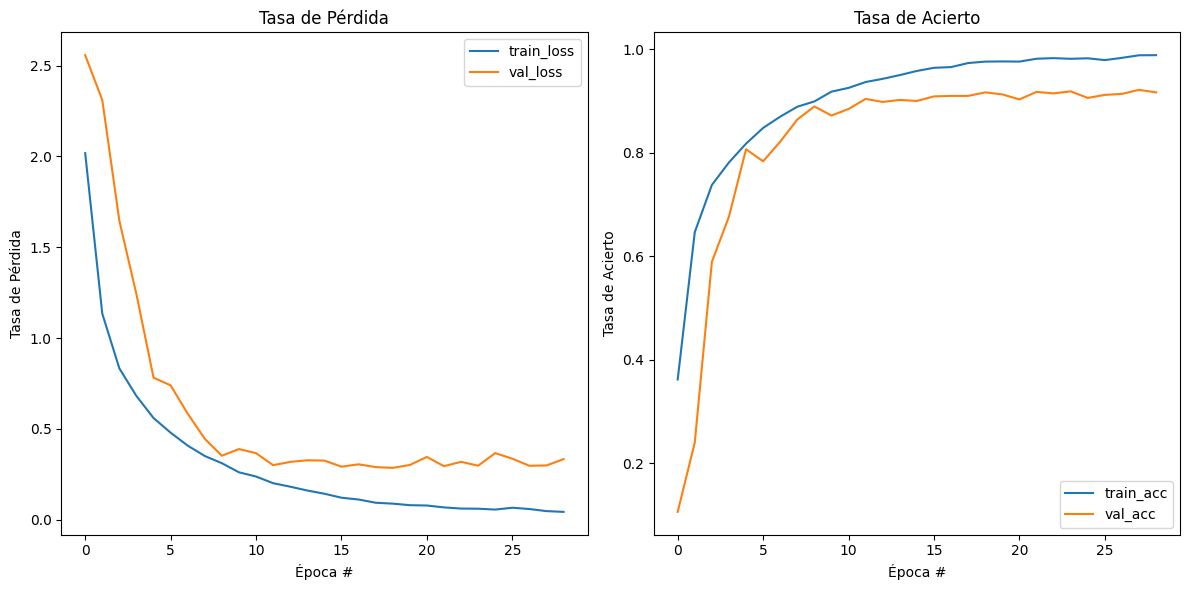

In [30]:
# Crea una figura con dos subgráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 fila, 2 columnas

# Gráfico 1: Tasa de pérdida (Loss)
ax1.plot(H.history["loss"], label="train_loss")
ax1.plot(H.history["val_loss"], label="val_loss")
ax1.set_title("Tasa de Pérdida")
ax1.set_xlabel("Época #")
ax1.set_ylabel("Tasa de Pérdida")
ax1.legend(loc="upper right")

# Gráfico 2: Tasa de acierto (Accuracy)
ax2.plot(H.history["accuracy"], label="train_acc")
ax2.plot(H.history["val_accuracy"], label="val_acc")
ax2.set_title("Tasa de Acierto")
ax2.set_xlabel("Época #")
ax2.set_ylabel("Tasa de Acierto")
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

Evaluación del modelo

Forma final de x_test: (6349, 64, 65, 1)
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

        CERO       1.00      0.99      0.99       659
       CINCO       1.00      1.00      1.00       658
      CUATRO       0.99      1.00      1.00       679
         DOS       0.99      1.00      0.99       671
     FIREFOX       1.00      0.99      1.00       576
         HEY       0.99      0.99      0.99       630
          NO       0.99      1.00      0.99       673
       NUEVE       0.99      1.00      0.99       656
        OCHO       1.00      1.00      1.00       670
        SEIS       1.00      0.99      0.99       674
          SI       1.00      1.00      1.00       697
       SIETE       1.00      0.99      1.00       679
        TRES       0.99      1.00      0.99       673
         UNO       1.00      1.00      1.00       658

    accuracy                           1.00      9253
   macro av

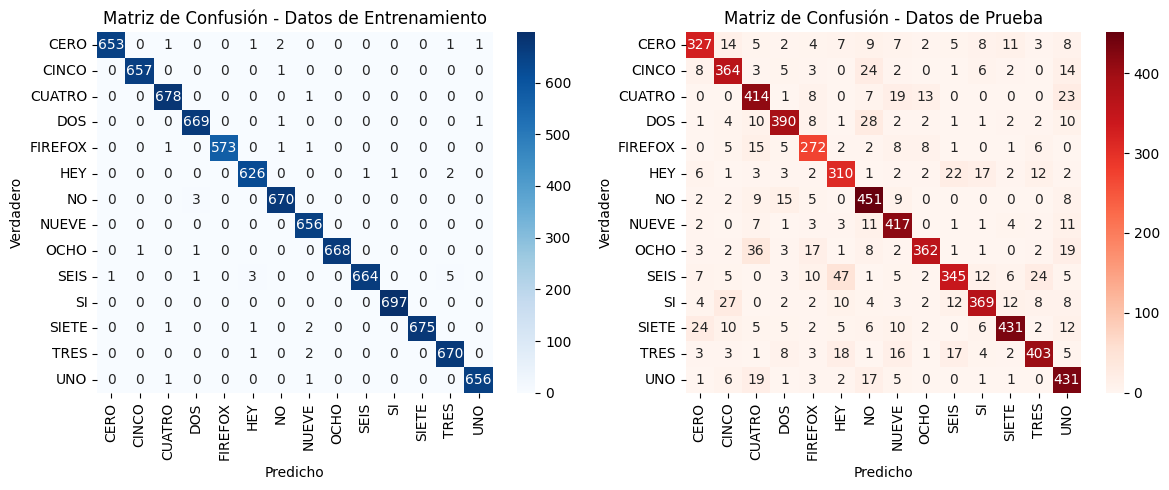

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

def evaluar(x_data, y_data, bin_tr):
    y_pred = model.predict(x_data)
    y_pred_lbl = bin_tr.inverse_transform(y_pred)
    y_data_lbl = bin_tr.inverse_transform(y_data)
    conf_mt = confusion_matrix(y_data_lbl, y_pred_lbl)
    acc = (y_pred_lbl == y_data_lbl).sum()/len(y_data_lbl)
    report = classification_report(y_data_lbl, y_pred_lbl)
    return (acc, conf_mt, report)

# Verificación con datos de testeo


# Carga las imágenes a partir de los nombres de archivos
y_test = binarizador.transform(test_labels_list)
x_test = np.array(test_img_list)

# Si x_test tiene forma (n_samples, height, width), añadir dimensión de canal
if len(x_test.shape) == 3:
    x_test = np.expand_dims(x_test, axis=-1)
    print(f"Forma final de x_test: {x_test.shape}")


# Evalua el modelo en datos de entrenamiento y datos de prueba
(acc_train, conf_mt_train, report_train) = evaluar(x_train, y_train, binarizador)
(acc_test, conf_mt_test, report_test) = evaluar(x_test, y_test, binarizador)

# Crear una figura con dos subgráficos uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: Matriz de confusión para datos de entrenamiento con Seaborn
sns.heatmap(conf_mt_train, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=CLASES, yticklabels=CLASES)
ax1.set_title('Matriz de Confusión - Datos de Entrenamiento')
ax1.set_xlabel('Predicho')
ax1.set_ylabel('Verdadero')
print(report_train)

# Gráfico 2: Matriz de confusión para datos de prueba con Seaborn
sns.heatmap(conf_mt_test, annot=True, fmt='d', cmap='Reds', ax=ax2, xticklabels=CLASES, yticklabels=CLASES)
ax2.set_title('Matriz de Confusión - Datos de Prueba')
ax2.set_xlabel('Predicho')
ax2.set_ylabel('Verdadero')
print(report_test)

plt.tight_layout()
plt.show()